In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *


root='/data'
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
%run UtilityTools.ipynb

defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

ERROR:root:File `'Animal_Tags.ipynb.py'` not found.


ERROR:root:File `'BatchRatBehavior.ipynb.py'` not found.


ERROR:root:File `'plotRat_documentation_3_KinematicsInvestigation.ipynb.py'` not found.


ERROR:root:File `'plotRat_documentation_1_GeneralBehavior.ipynb.py'` not found.


ERROR:root:File `'loadRat_documentation.ipynb.py'` not found.


ERROR:root:File `'RunBatchRat_3_CompareGroups.ipynb.py'` not found.


ERROR:root:File `'UtilityTools.ipynb.py'` not found.


### trimmed mean function
averaging after removing outliers (-+3 SDs)

In [4]:
def trimmed_mean(x):
    if len(x)<50:
        return np.nanmean(x)
    SD=np.nanstd(x)
    MEAN=np.nanmean(x)
    out=scipy.stats.tmean(x, limits=(MEAN-3*SD,MEAN+3*SD), inclusive=(False, False), axis=None)
    return out

### initial position's role in entrance time

In [73]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':'10',
     'Speed':'10',
     'Tag':'Control'
              }
SESSION_LIMIT=5

median entrance time of trials in different initial position bins

removed sessions: 1
good trials: 10839


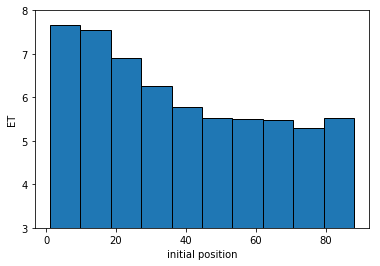

In [38]:
animalList=batch_get_animal_list(root,AnimalProfile)
rawPos=[]
ET=[]
countN=0
countP=0
for animal in  animalList:
    sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
    if SESSION_LIMIT >0:
        tmp=sessionDict['Sessions'][:SESSION_LIMIT]
    else:
        tmp=sessionDict['Sessions'][SESSION_LIMIT:]
    
    for session in tmp:
        picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','rawbehaviordata.p')
        with open(picklePath,'rb') as f:
            data=pickle.load(f)
        try:
            rawPos0=[data['rawPosition'][i][0] for i in data['rawPosition']]
            ET0=data['entranceTime']
        except:pass
        if len(ET0)==len(rawPos0):
            rawPos.extend(rawPos0)
            ET.extend(ET0)
            countP+=len(ET0)
        else:
            countN+=1

print('removed sessions:',countN)
print('good trials:',countP)
ET=np.array(ET)
rawPos=np.array(rawPos)
stat,bins,_=scipy.stats.binned_statistic(rawPos,ET, statistic='median')
plt.bar(bins[0:-1]+5,stat,width=bins[1]-bins[0],edgeColor='k')
plt.ylim(3,8)
plt.xlabel('initial position')
plt.ylabel('ET')
plt.show()

P(correct trial | initial position)

In [92]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':'10',
     'Speed':['10'],
     'Tag':'Control'
              }
SESSION_LIMIT=-5
GoalTime=7
MaxTrialTime=15

removed sessions: 6
session limit: -5


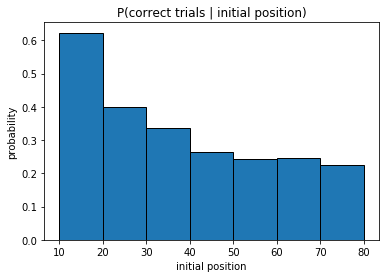

In [93]:
animalList=batch_get_animal_list(root,AnimalProfile)

bins=[10,20,30,40,50,60,70,80]
pos=[]
et=[]
for animal in  animalList:
    sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
    if SESSION_LIMIT >0:
        tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
    else:
        tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
        
    for session in tmp:
        picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
        with open(picklePath,'rb') as f:
            data=pickle.load(f)
        try:
            rawPos0=np.array([data['position'][i][0] for i in data['position']])
            ET0=np.array(data['entranceTime'])
        except:
            ET0=[]
            rawPos0=[0,0]
        if len(ET0)==len(rawPos0):
            pos.extend(rawPos0.tolist())
            et.extend(ET0.tolist())
        else:
            countN+=1
def p_correct(a):
    return sum(np.logical_and(a >= GoalTime, a < MaxTrialTime))/len(a)
print('removed sessions:',countN)
print('session limit:',SESSION_LIMIT)
et=np.array(et)
pos=np.array(pos)
stat,bins,_=scipy.stats.binned_statisticv(pos,et, statistic=p_correct,bins=bins)
plt.bar(bins[0:-1]+5,stat,width=bins[1]-bins[0],edgeColor='k')
plt.title('P(correct trials | initial position)')
plt.xlabel('initial position')
plt.ylabel('probability')
plt.show()

probablity distribution of correct trials along the length of the treadmill

In [13]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':'10',
     'Speed':['10'],
     'Tag':'Control'
              }
SESSION_LIMIT=-55
GoalTime=7
MaxTrialTime=15

removed sessions: 4
good trials: 2392
session limit: -55


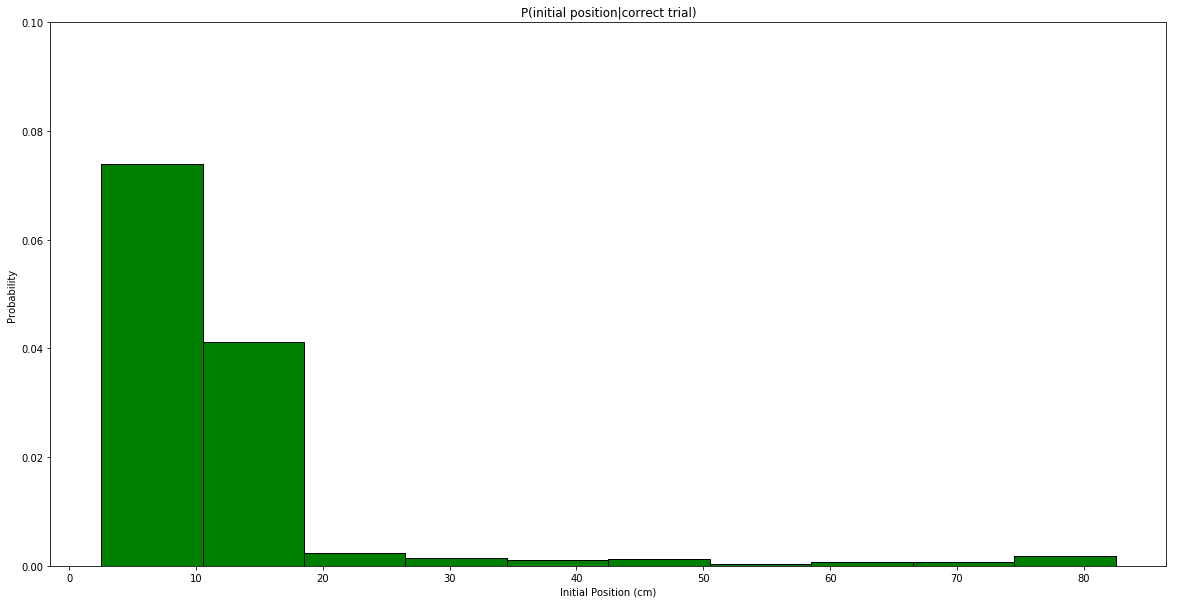

In [21]:
animalList=batch_get_animal_list(root,AnimalProfile)
animalList=['Rat084']
rawPos=[]
countN=0
countP=0
for animal in  animalList:
    sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
    if SESSION_LIMIT >0:
        tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
    else:
        tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
    for session in tmp:
        picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
        with open(picklePath,'rb') as f:
            data=pickle.load(f)
        try:
            rawPos0=np.array([data['position'][i][0] for i in data['position']])
            ET0=np.array(data['entranceTime'])
        except:
            ET0=[]
            rawPos0=[0,0]
        if len(ET0)==len(rawPos0):
            rawPos0=rawPos0[np.logical_and(ET0 >= GoalTime, ET0 < MaxTrialTime)]
            rawPos.extend(rawPos0)
            countP+=len(rawPos0)
        else:
            countN+=1

print('removed sessions:',countN)
print('good trials:',countP)
print('session limit:',SESSION_LIMIT)
rawPos=np.array(rawPos)
plt.figure(figsize=(20,10))
plt.hist(rawPos,normed=True,edgecolor='k',color='g')
plt.xlabel('Initial Position (cm)')
plt.ylabel('Probability')
plt.title('P(initial position|correct trial)')
plt.ylim(0,.1)

plt.show()

### effect of initial position on the trajectory

also number of in-the-back-trials seem to decline with learning

In [50]:
def position_based_trajectory(root,animalList,TRD_RANGE,SESSION_LIMIT,MAX_L):
    traj=[]
    Ntrial=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            try:
                with open(picklePath,'rb') as f:
                    data=pickle.load(f)
                goodTrials=[trial for trial in data['position'] if data['position'][trial][0] > TRD_RANGE[0] and data['position'][trial][0] < TRD_RANGE[1]]
                Ntrial+=len(goodTrials)
            except:
                goodTrials=[]

            traj.extend([data['position'][i] for i in goodTrials])

    Traj=np.ones((MAX_L,len(traj)))*np.nan

    for i,pos in enumerate(traj):
        Traj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]
    print(Ntrial)    
    return Traj,Ntrial

2103


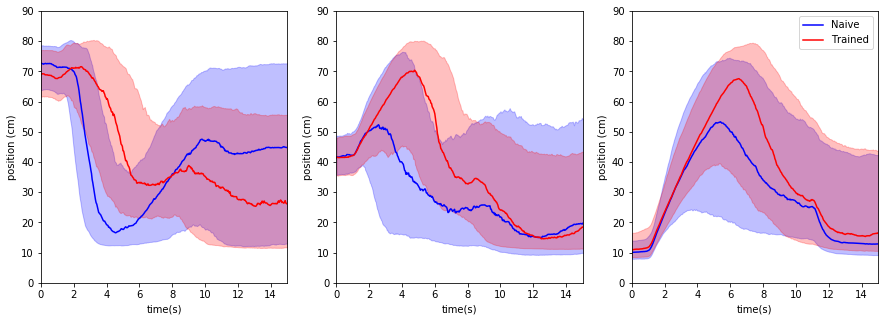

In [51]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10'],
     'Speed':['10'],
     'Tag':'Control-NoTimeout'
              }

animalList=batch_get_animal_list(root,AnimalProfile)

SESSION_LIMIT=5
TRD_RANGE   = [[55,100],[30,55],[0,25]]
MAX_L        =500
plt.figure(figsize=[15,5])
for i in range(len(TRD_RANGE)):
    plt.subplot(1,len(TRD_RANGE),i+1)
    TrajNaive,_=position_based_trajectory(root,animalList,TRD_RANGE[i],SESSION_LIMIT,MAX_L)
    SESSION_LIMIT=-SESSION_LIMIT
    TrajTrained,_=position_based_trajectory(root,animalList,TRD_RANGE[i],SESSION_LIMIT,MAX_L)
    SESSION_LIMIT=-SESSION_LIMIT
    
    plt.plot(np.arange(MAX_L)/25,np.nanmedian(TrajNaive,axis=1),'b',label='Naive')
    plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(TrajNaive, 25, axis=1),np.nanpercentile(TrajNaive, 75, axis=1),color='blue',alpha=0.25)
    plt.plot(np.arange(MAX_L)/25,np.nanmedian(TrajTrained,axis=1),'r',label='Trained')
    plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(TrajTrained, 25, axis=1),np.nanpercentile(TrajTrained, 75, axis=1),color='red',alpha=0.25)

    plt.xlabel('time(s)')
    plt.ylabel('position (cm)')
    plt.xlim([0,15])
    plt.ylim([0,90])
plt.legend();

### percentage of fast correct trials in trained sessions 

+trial: 5
-trial: 0


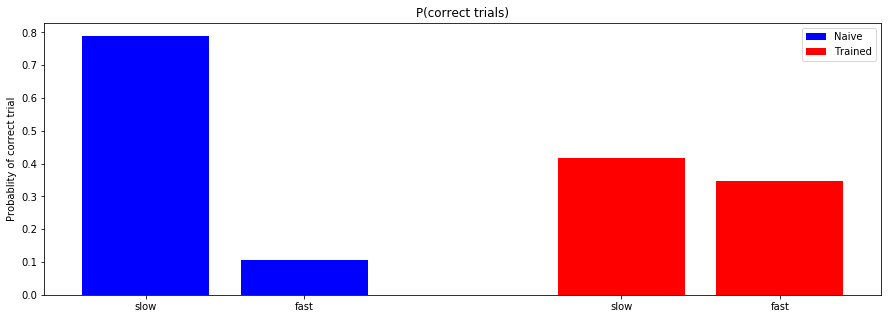

In [16]:
def P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE):
    animalList=batch_get_animal_list(root,AnimalProfile)
    N=0
    goodN=0
    countN=0
    countP=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            filePath=os.path.join(root,animal,'Experiments',session,session)
            with open(picklePath,'rb') as f:
                data=pickle.load(f)
            try:
                spd0=read_in_file(filePath,paramName=' ',extension='.variablespeed',valueType=float)
                ET0=np.array(data['entranceTime'])
            except:
                spd0=[]
                ET0=[0,0]
            if len(ET0)==len(spd0):
                goodTrial=ET0[np.logical_and(spd0 >= SPEED_RANGE[0], spd0 <SPEED_RANGE[-1])]
                N+=np.sum(ET0>=7)
                goodN+=np.sum(goodTrial>=7)
                countP+=1
            else:
                countN+=1
    print('+trial:',countP)
    print('-trial:',countN)
    return goodN,N    


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     #'initialSpeed':['var'],
     'Speed':['var'],
     'Tag':'Early-Lesion_DMS-Early-var'
              }

animalList=batch_get_animal_list(root,AnimalProfile)
SESSION_LIMIT=5
SPEED_RANGE        =[[5,15],[20,30]]
plt.figure(figsize=[15,5])
goodN0S,N0=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN0F,N0=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT
goodN1S,N1=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN1F,N1=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT

plt.bar([0,1],[goodN0S/N0,goodN0F/N0],color='b',label='Naive')
plt.bar([3,4],[goodN1S/N1,goodN1F/N1],color='r',label='Trained')
plt.xticks([0,1,3,4],['slow','fast','slow','fast'])
plt.legend();
plt.title('P(correct trials)');
plt.ylabel('Probablity of correct trial');

### trajectory evolution for bad/good trials

In [54]:
def trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L):
    goodTraj=[]
    badTraj=[]
    Ntrial=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            try:
                with open(picklePath,'rb') as f:
                    data=pickle.load(f)
                ET0=np.array(data['entranceTime'])
                goodTrials=np.nonzero(np.logical_and(ET0>=7, ET0<15))[0].tolist()
                badTrials =np.nonzero(ET0< 7)[0].tolist()
                Ntrial+=len(goodTrials)
            except Exception as e:
                print(repr(e))
                goodTrials=[]
                badTrials=[]

            goodTraj.extend([data['position'][i] for i in goodTrials if i+1 in data['realTrials']])
            badTraj.extend ([data['position'][i] for i in badTrials  if i+1 in data['realTrials']])

    GoodTraj=np.ones((MAX_L,len(goodTraj)))*np.nan
    BadTraj =np.ones((MAX_L,len(badTraj )))*np.nan

    for i,pos in enumerate(goodTraj):
        GoodTraj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]
    for i,pos in enumerate(badTraj):
        BadTraj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]

    print(Ntrial)    
    return GoodTraj,BadTraj

5336


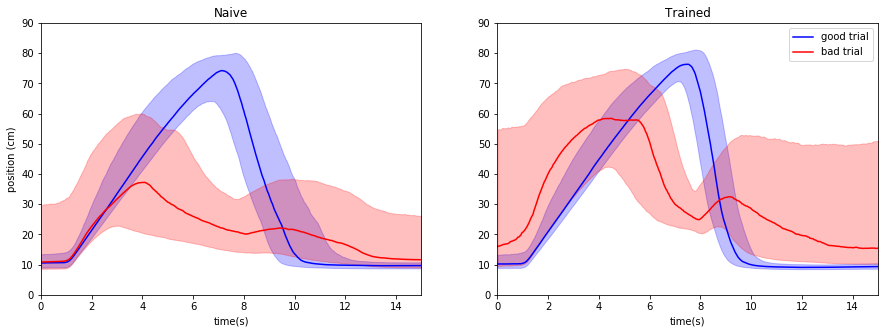

In [56]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10'],
     'Speed':['10'],
     'Tag':'Control'
              }

animalList=batch_get_animal_list(root,AnimalProfile)

SESSION_LIMIT=5
MAX_L        =500
plt.figure(figsize=(15,5))
goodNaive,badNaive=trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L)
SESSION_LIMIT=-SESSION_LIMIT
goodTrained,badTrained=trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L)
SESSION_LIMIT=-SESSION_LIMIT

plt.subplot(1,2,1)
plt.plot(np.arange(MAX_L)/25,np.nanmedian(goodNaive,axis=1),'b',label='good trial')
plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(goodNaive, 25, axis=1),np.nanpercentile(goodNaive, 75, axis=1),color='blue',alpha=0.25)
plt.plot(np.arange(MAX_L)/25,np.nanmedian(badNaive,axis=1),'r',label='bad trial')
plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(badNaive, 25, axis=1),np.nanpercentile(badNaive, 75, axis=1),color='red',alpha=0.25)
plt.xlabel('time(s)')
plt.ylabel('position (cm)')
plt.xlim([0,15])
plt.ylim([0,90])
plt.title('Naive')
plt.subplot(1,2,2)
plt.plot(np.arange(MAX_L)/25,np.nanmedian(goodTrained,axis=1),'b',label='good trial')
plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(goodTrained, 25, axis=1),np.nanpercentile(goodTrained, 75, axis=1),color='blue',alpha=0.25)
plt.plot(np.arange(MAX_L)/25,np.nanmedian(badTrained,axis=1),'r',label='bad trial')
plt.fill_between(np.arange(MAX_L)/25,np.nanpercentile(badTrained, 25, axis=1),np.nanpercentile(badTrained, 75, axis=1),color='red',alpha=0.25)

plt.xlabel('time(s)')
plt.xlim([0,15])
plt.ylim([0,90])
plt.legend();
plt.title('Trained');

### Permutation Hypothesis Testing

In [246]:
class permtest_output:
    def __init__(self,D0,shuffledD=None,p_val=None,band=None, pairwise_CI=None,sig_signal=None):
        self.statistic=D0
        self.shuffled_data=shuffledD
        self.p_val=p_val
        self.significant=sig_signal
        self.boundary=band
        self.pairwise_alpha=pairwise_CI
        self.significant=sig_signal

        
def perm_statistic(x,y,Nx,Ny,sigma=0):
    
    if len(x) <2:
        return (x/Nx)-(y/Ny)
    
    #the gaussian kernel
    x_smooth=scipy.ndimage.filters.gaussian_filter1d(x, sigma=sigma, order=0, mode='constant', cval=0, truncate=4.0)
    y_smooth=scipy.ndimage.filters.gaussian_filter1d(y, sigma=sigma, order=0, mode='constant', cval=0, truncate=4.0)
    
    return (x_smooth/Nx)-(y_smooth/Ny)
    
def permtest(x,y, iterN=1000,sigma=0.05):
    """
    Permutation test as to whether x>y or not.
    x,y:
    represent the data. they could be eitherr one dimentional(several realizations)
    or 2-D (several realizaions through out the time/space/... course)
        EX: x.shape==(15,500) means 15 trials/samples over 500 time bins
    
    iterN:
    number of iterations used to shuffle
    
    sigma:
    the standard deviation of the gaussian kernel used for smoothing when there are multiple data points,
    based on the Fujisawa 2008 paper, default value: 0.05
    """
    
    #input check
    if x.ndim>2 or y.ndim>2:
        raise ValueError('bad input dimentions')
    elif x.ndim==1 or y.ndim==1:
        x=np.reshape(x,(len(x),1))
        y=np.reshape(y,(len(y),1))
    
    #computing the tset statistic
    xTrial,yTrial=x.shape[0],y.shape[0]
    
    x_superimpos=np.nansum(x,axis=0)
    y_superimpos=np.nansum(y,axis=0)
    
    D0=perm_statistic(x_superimpos,y_superimpos,x.shape[0],y.shape[0])
    
    # shuffling the data
    Dshuffled=np.ones((iterN,len(x_superimpos)))*np.nan
    for i in range(iterN):
        tmpShuffle=np.concatenate((x,y),axis=0)
        np.random.shuffle(tmpShuffle)  #works in-plcae
        xNew,yNew=tmpShuffle[:xTrial,:],tmpShuffle[xTrial:,:]
        
        xNew_superimpos=np.nansum(xNew,axis=0)
        yNew_superimpos=np.nansum(yNew,axis=0)
        
        Dshuffled[i,:]=perm_statistic(xNew_superimpos,yNew_superimpos,xNew.shape[0],yNew.shape[0],sigma)
    
    if len(D0)<2:  #single point comparison
        p_val0=np.sum(Dshuffled>=D0,axis=0)/(iterN+1)
        return permtest_output(D0=D0,p_val=p_val0,shuffledD=Dshuffled,sig_signal=bool(p_val0<=0.05))
    
    #global bands
    alpha=100
    CI=5  #global confidance interval
    pairwise_high_band=np.percentile(a=Dshuffled,q=100-CI,axis=0)
    
    while alpha>=5:
        high_band=np.percentile(a=Dshuffled,q=100-CI,axis=0)
        breaks=np.sum([np.sum(Dshuffled[i,:]>high_band)>1 for i in range(iterN)])
        alpha=(breaks/iterN)*100
        CI=0.95*CI
        print("Global Confidence interval at ",CI,'\nComputing again...\n')
    
    #finding significant bins
    global_sig=D0>high_band
    pairwise_sig=D0>pairwise_high_band
    sigIndex=np.where(global_sig)[0]
    
    for i in sigIndex:
        if i==0 or i==len(global_sig):
            continue
        global_sig[np.min((np.where(pairwise_sig[:i])[0][-1],i)):np.max((np.where(pairwise_sig[i:])[0][-1],i))]=True
    
    return permtest_output(D0=D0,shuffledD=Dshuffled,sig_signal=global_sig,p_val=CI,band=high_band)

In [5]:
y=[52.0, 57.0, 65.0, 35.0, 72.0, 60.0, 68.0, 40.0, 32.0, 62.0, 60.0, 45.0, 60.0, 57.0]
x=[72.0, 38.0, 72.0, 72.0, 72.0, 75.0, 72.0, 2.0, 18.0, 65.0]
x=np.random.normal(loc=1.5, scale=1.0, size=(10,100))
y=np.random.normal(loc=1.5, scale=1.0, size=(10,100))

a=permtest(np.array(x),np.array(y), iterN=10000)
a.__dict__

NameError: name 'permtest' is not defined

### Learning Duration/ Number of trials

???

In [ ]:
def trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L):
    goodTraj=[]
    badTraj=[]
    Ntrial=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            try:
                with open(picklePath,'rb') as f:
                    data=pickle.load(f)
                ET0=np.array(data['entranceTime'])
                goodTrials=np.nonzero(np.logical_and(ET0>=7, ET0<15))[0].tolist()
                badTrials =np.nonzero(ET0< 7)[0].tolist()
                Ntrial+=len(goodTrials)
            except Exception as e:
                print(repr(e))
                goodTrials=[]
                badTrials=[]

            goodTraj.extend([data['position'][i] for i in goodTrials if i+1 in data['realTrials']])
            badTraj.extend ([data['position'][i] for i in badTrials  if i+1 in data['realTrials']])

    GoodTraj=np.ones((MAX_L,len(goodTraj)))*np.nan
    BadTraj =np.ones((MAX_L,len(badTraj )))*np.nan

    for i,pos in enumerate(goodTraj):
        GoodTraj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]
    for i,pos in enumerate(badTraj):
        BadTraj[:min(len(pos),MAX_L),i]=pos[:min(len(pos),MAX_L)]

    print(Ntrial)    
    return GoodTraj,BadTraj

In [143]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10'],
     'Speed':['10'],
     'Tag':'Control'
              }
animalList=batch_get_animal_list(root,AnimalProfile)

SESSION_LIMIT=5
MAX_L        =500
plt.figure(figsize=(15,5))
goodNaive,badNaive=trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L)
SESSION_LIMIT=-SESSION_LIMIT
goodTrained,badTrained=trajectory_evolution(root,animalList,SESSION_LIMIT,MAX_L)
SESSION_LIMIT=-SESSION_LIMIT


## trajectory distance matrix instead of fucking correlation

In [57]:
def compute_rmse(data,maxTreadmillLength=90):
    '''
    Compute the rmse of the position between trial start and trial stop (treadmill stop)
    Returns the ...
    '''
    allTraj=get_positions_array_beginning(data)
    NbTrial=allTraj.shape[0]
    rmse=np.ones((NbTrial,NbTrial))*(-1)

    for i in range(NbTrial):
        for j in range(i+1,NbTrial):
            maxL=min([np.sum(np.logical_not(np.isnan(allTraj[i,:]))),np.sum(np.logical_not(np.isnan(allTraj[j,:])))])
            rmse[i,j]=np.sqrt(np.sum((allTraj[i,:maxL]-allTraj[j,:maxL])**2)/maxL)
    out=np.triu(rmse,k=0)+np.triu(rmse,k=0).T #symetrical
    return out/maxTreadmillLength


29.2580645161 0.262986954016


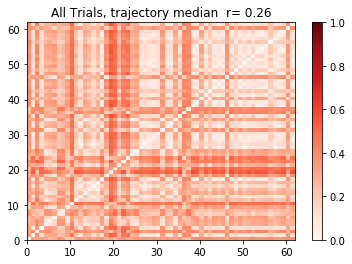

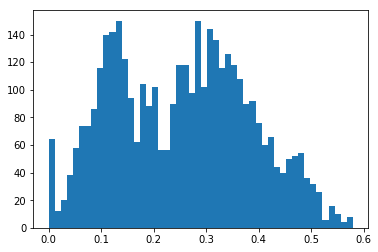

In [139]:
data=Data(root,'Rat077','Rat077_2016_10_07_10_15',defaultParam,redoPreprocess=False)
a,b=plot_rmse(data);
print(sum(b.flatten()<.25)/b.shape[0],a)
plt.figure()
plt.hist(b.flatten(),50);

#### trajectories aligned at their peak

In [238]:
def get_positions_array_peaks_aligned(data,onlyGood=False,raw=False):
    '''
    Returns array of position, align on detected peak,
    If one position is too short (detected end is before minTime), 
      the position is pad at the beginning and end with nan values
    '''
    if raw:
        posDict=data.rawPosition
    else:
        posDict=data.position
    #number of frames to keep 
    cs=data.cameraSamplingRate
    size=int(scipy.stats.mode(data.maxTrialDuration)[0]*cs)+1 #int(abs(minTime*cs))
    #put all positions in a 2D array
    allTraj=np.ones([max(posDict.keys())+1,size*2])*np.nan  #matrix of trial position*time
    for trial in posDict:
        if onlyGood and (trial not in data.goodTrials):
            continue
        
        #index where the trajectory begins and ends
        endIndex  =data.stopFrame[trial] if isNone(data.indexEndTrial[trial]) else data.indexEndTrial[trial]
        startIndex=data.startFrame[trial]
        pos=posDict[trial][startIndex:endIndex]
        peakIndex=np.argmax(pos)
        indexOffset=size-peakIndex
        allTraj[trial,indexOffset:indexOffset+len(pos)]=pos
    return allTraj


In [239]:
def plot_rmse(data,alignedOnBegining=True,onlyGood=False,raw=False):
    '''
    Compute the rmse of the position between trial start and trial stop (treadmill stop)
    plots and returns the RMSE matrix
    '''
    if alignedOnBegining:
        allTraj=get_positions_array_beginning(data,onlyGood=onlyGood,raw=raw)
    else:
        allTraj=get_positions_array_peaks_aligned(data,onlyGood=onlyGood,raw=raw)
    
    NbTrial=allTraj.shape[0]
    
    if NbTrial<3:
        title="Not enough trials"
        med=np.nan
        return med

    rmse=np.ones((NbTrial,NbTrial))*(-1)

    for i in range(NbTrial):
        rmse[i,i]=0
        for j in range(i+1,NbTrial):
            
            a=allTraj[i,:]-allTraj[j,:]
            rmse[i,j]=np.sqrt(np.nansum(a**2)/np.sum(np.logical_not(np.isnan(a))))
    
    RMSEmatrix=np.triu(rmse,k=0)+np.triu(rmse,k=0).T #symetrical
    RMSEmatrix/=data.treadmillRange[1]
    pp=plt.pcolor(RMSEmatrix,vmin=0,vmax=1,cmap="Reds")
    plt.colorbar(pp)
    plt.xlim([0,RMSEmatrix.shape[0]])
    plt.ylim([0,RMSEmatrix.shape[1]])
    
    #median of upper triangle of matrix
    coef=RMSEmatrix[np.tril_indices(RMSEmatrix.shape[0],-1)]
    #print(len(coef))
    m=np.nanmean(coef)
    maxSecond=allTraj.shape[1]/float(data.cameraSamplingRate)
    #title of the plot
    title=""
    if onlyGood:
        title="Good Trials"
    else:
        title="All Trials"

    title+=', trajectory m= %.2f'%m    
    plt.title(title)

    
    return m,RMSEmatrix

0.199721321857


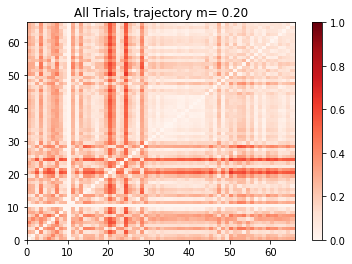

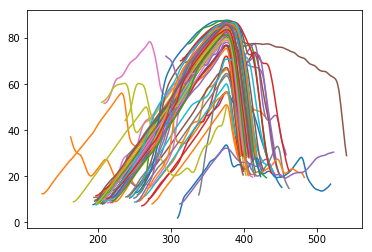

In [240]:
session='Rat164_2017_10_11_15_29'
data=Data(root,session[:6],session,defaultParam,redoPreprocess=False)
m,esme=plot_rmse(data,alignedOnBegining=False,onlyGood=False,raw=False)
print(m)
plt.figure()
traj=get_positions_array_peaks_aligned(data,onlyGood=False,raw=False)
plt.plot(traj.T);

## Trajectory Distribution

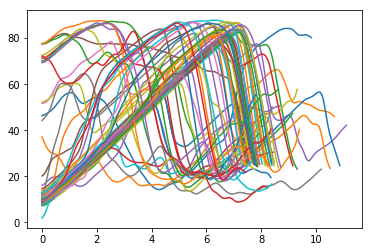

In [20]:
# session='Rat164_2017_10_11_15_29'
# data=Data(root,session[:6],session,defaultParam,redoPreprocess=False)
# allTraj=get_positions_array_beginning(data,False).T
# plt.plot(np.arange((allTraj.shape[0]))/data.cameraSamplingRate,allTraj);

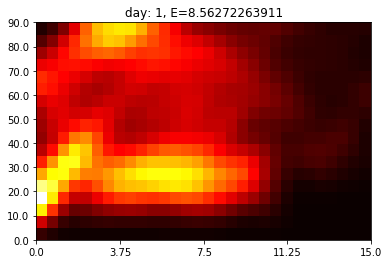

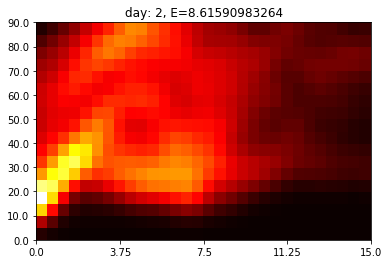

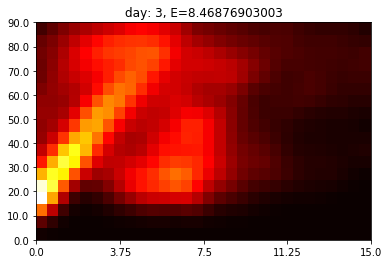

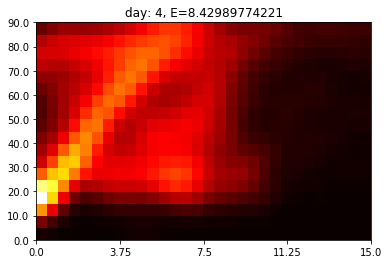

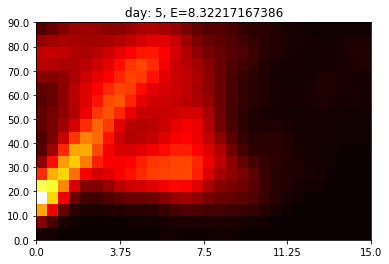

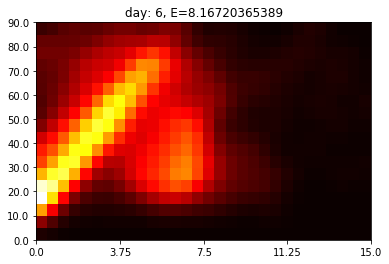

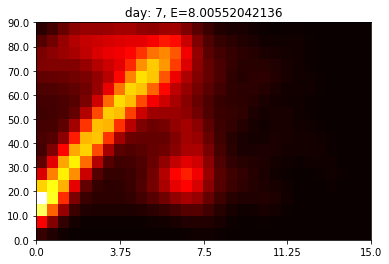

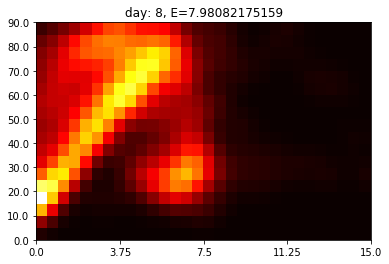

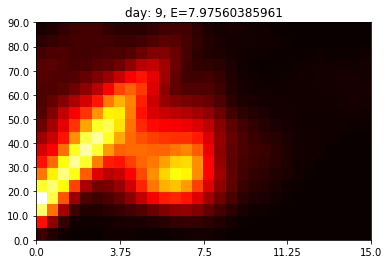

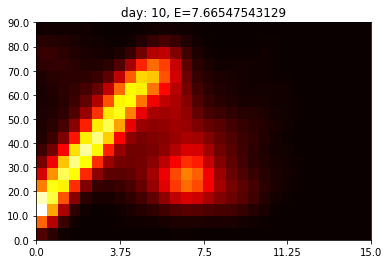

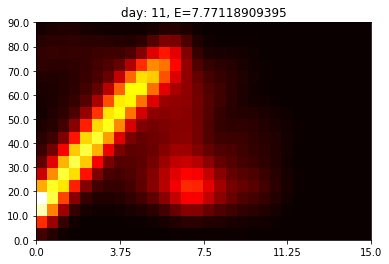

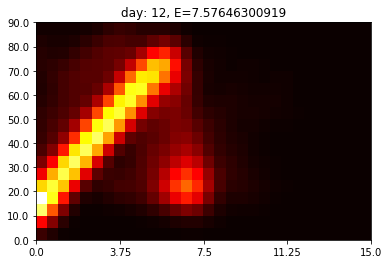

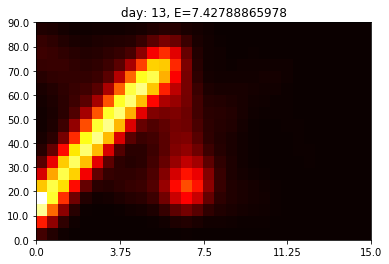

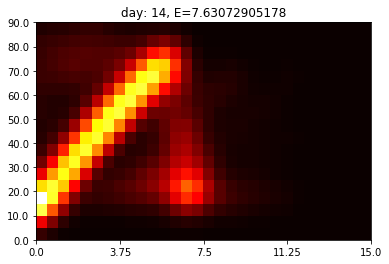

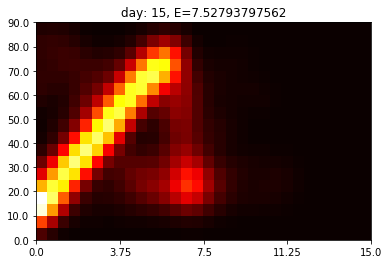

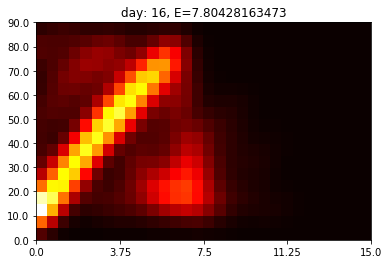

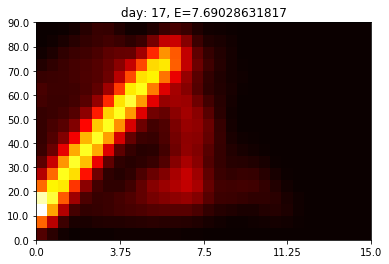

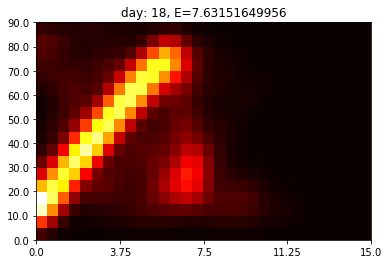

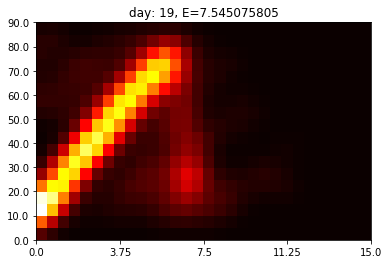

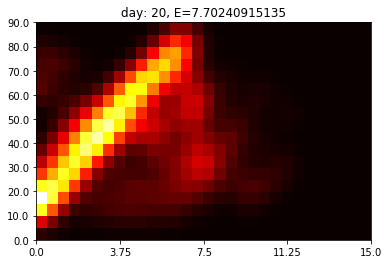

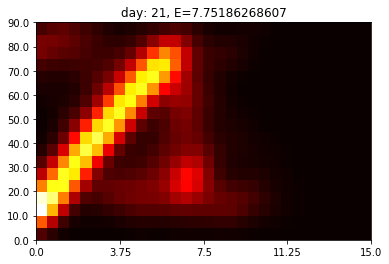

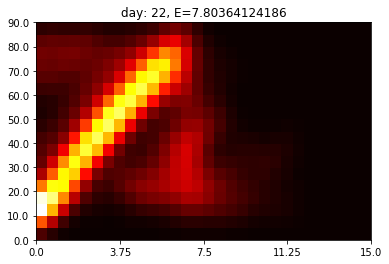

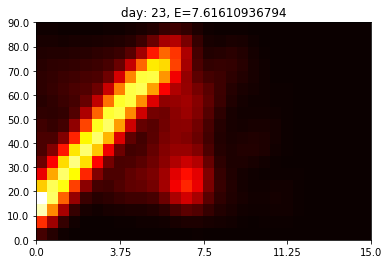

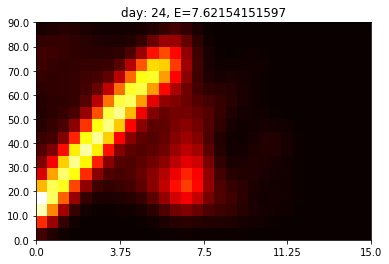

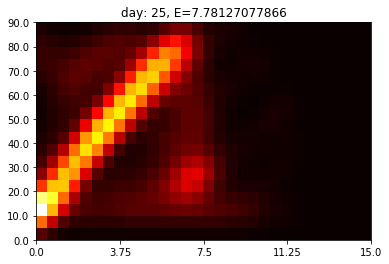

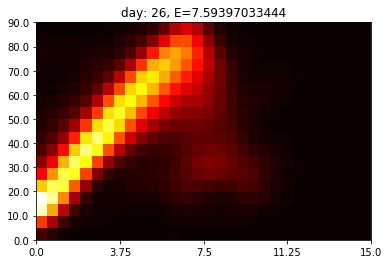

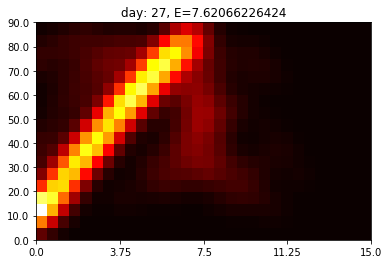

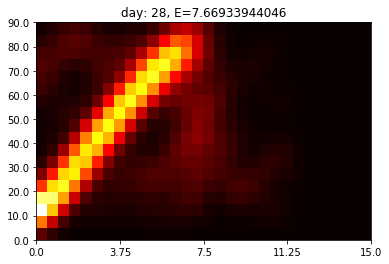

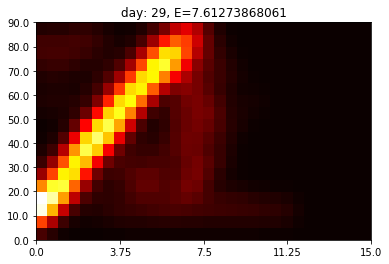

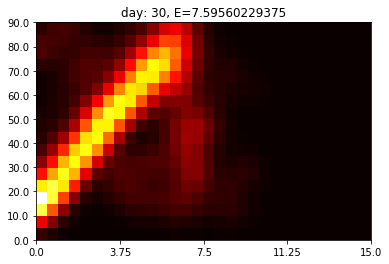

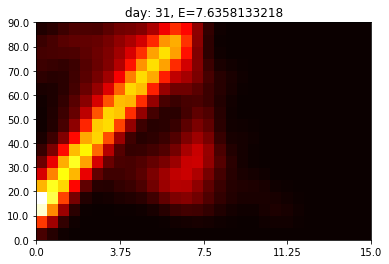

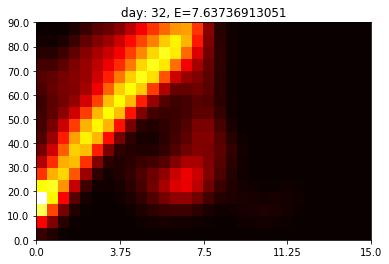

In [41]:
sessionDict=batch_get_session_list(root,["Rat166"],profile={'Tag':'Control','Speed':'10','Type':'Good'})
sessionList=sessionDict['Sessions']

H=[]
for i,session in enumerate(sessionList):
    data=Data(root,session[:6],session,defaultParam,redoPreprocess=False)
    fig=plt.figure()
    ax=plt.subplot(111)
    h=plot_trajectory_PDF(data,TimeRes=.5,PosRes=5,onlyGood=False)
    plt.title(('day: '+str(i+1) + ', E='+ str(twoD_entropy(h))))
    H.append(h)
#     plt.close()
#     plt.plot(H,'r-*')
#     plt.ylim([7,10])
#     plt.title(session[:6])

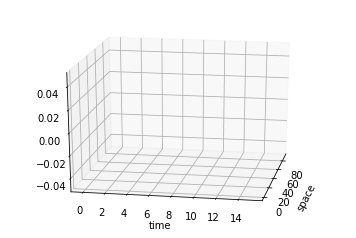

In [481]:
Y = np.linspace(0, 15, trajDis.shape[0])
X = np.linspace(0, 90, trajDis.shape[1])
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, trajDis/sum(trajDis.flatten()),cmap=cm.coolwarm,
                       linewidth=0,antialiased=False)
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.invert_xaxis()
ax.view_init(elev=20,azim=10)
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


### 2d entropy

In [4]:
def twoD_entropy(trajDist):
    H=0
    for i in range(trajDist.shape[0]):
        for j in range(trajDist.shape[1]):
            try:
                H+=trajDist[i,j]*math.log(float(trajDist[i,j]),2)
            except:
                pass
    H=-H
    return H

## making video

A single trial

In [102]:
dpi = 100

def ani_frame(data,trial):
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.set_aspect('equal')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    allTraj=get_positions_array_beginning(data)
    time=(np.arange(allTraj.shape[1])/data.cameraSamplingRate)+data.cameraToTreadmillDelay
    ax.set_xlim([time[0],10])
    ax.set_ylim([0,90])
    im = ax.plot(time[:1],allTraj[trial,:1],'k')
    
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        im = ax.plot(time[:n],allTraj[trial,:n],color='k')
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,len(time),interval=np.median(np.diff(time))*1000,blit=True)
    writer = animation.writers['ffmpeg'](fps=data.cameraSamplingRate,codec=None)

    ani.save('/home/david/Mostafa/demo.mp4',writer=writer,dpi=dpi)
    return ani


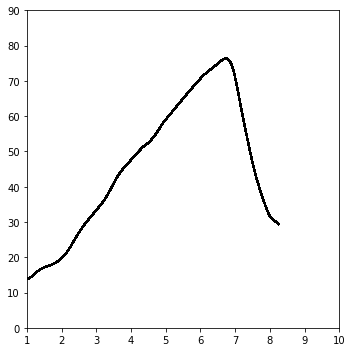

In [103]:
session="Rat167_2018_01_09_15_14"
data=Data(root,session[:6],session,defaultParam,redoPreprocess=False)
ani_frame(data,10)

#### multiple trials
works if all the trials are OK, (fix the videofile length problem)

In [2]:
dpi = 50

def ani_frame(data,trials=[0]):
    fig = plt.figure()
    fig.set_size_inches([5,5])
    ax = fig.add_subplot(111)
    allTraj=get_positions_array_beginning(data)
    #control for the extra 1 s in the begining of the video
    allTraj=np.concatenate((np.ones((allTraj.shape[0],int(data.cameraToTreadmillDelay*data.cameraSamplingRate)))*np.nan,allTraj),axis=1)
    time=np.arange(allTraj.shape[1])/data.cameraSamplingRate-data.cameraToTreadmillDelay
    ax.set_xlim([0,10])
    ax.set_ylim([0,90])
    cmap = plt.get_cmap('cool')
    colors = [cmap(i) for i in np.linspace(0, 1, len(trials))]
    
    im = ax.plot(time[:1],allTraj[trials[0],:1],color=colors[0])
    tight_layout()


    def update_img(IN):
        global im
        n,trial,i=IN
        if n <= int((data.entranceTime[trial]+data.cameraToTreadmillDelay)*data.cameraSamplingRate):
            im = ax.plot(time[:n],allTraj[trial,:n],color=colors[i])
        return im

    frames=[(t,trial,i) for i,trial in enumerate(trials) for t in range(int((data.entranceTime[trial]+data.interTrialDuration[trial]+data.cameraToTreadmillDelay)*data.cameraSamplingRate))]
    ani = animation.FuncAnimation(fig=fig,func=update_img,frames=frames,interval=1e3/data.cameraSamplingRate)
    writer = animation.writers['ffmpeg'](fps=data.cameraSamplingRate,codec=None)

    ani.save('/home/david/Mostafa/demo.mp4',writer=writer,dpi=dpi)
    print("Done!")
    return ani


Done!


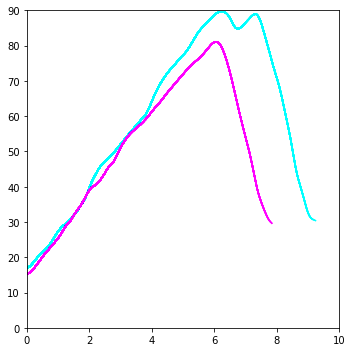

In [3]:
session="Rat167_2018_01_09_15_14"
data=Data(root,session[:6],session,defaultParam,redoPreprocess=False)
ani=ani_frame(data,trials=[2,3])